In [1]:
# This notebook somewhat follows the tutorials from here:
# https://www.tensorflow.org/versions/0.6.0/tutorials/mnist/pros/index.html

import numpy as np
import tensorflow as tf

% matplotlib inline
import matplotlib.pyplot as plt

import sys
if '../code' not in sys.path:
    sys.path.append('../code')

%reload_ext autoreload
%autoreload 1

In [2]:
%aimport mnist_downloader
trainx, trainy, testx, testy = mnist_downloader.read_data_sets(
    '../data', one_hot=True, exact_inputs=False)

from tabulate import tabulate

print(tabulate(
    [['train', trainx.shape, trainy.shape],
     ['test', testx.shape, testy.shape]],
    ['Data Set', 'x {}'.format(trainx.dtype), 'y {}'.format(trainy.dtype)],
    tablefmt='grid'))

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../data/t10k-labels-idx1-ubyte.gz
+------------+--------------+-------------+
| Data Set   | x float32    | y float32   |
+============+==============+=============+
| train      | (60000, 784) | (60000, 10) |
+------------+--------------+-------------+
| test       | (10000, 784) | (10000, 10) |
+------------+--------------+-------------+


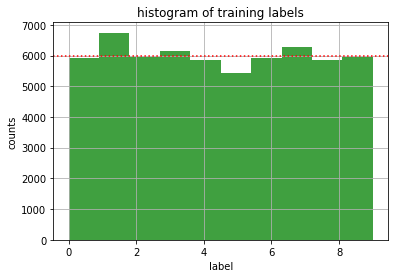

In [3]:
# Verify dataset balance

plt.hist(trainy.argmax(1), 10, facecolor='green', alpha=0.75)
plt.axhline(len(trainy) / 10, color='red', ls=':')
plt.xlabel('label')
plt.ylabel('counts')
plt.title(r'histogram of training labels')
plt.grid(True)

plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_and_validx = trainx
train_and_validy = trainy
trainx, validx, trainy, validy = train_test_split(
    train_and_validx, train_and_validy, test_size=0.3, random_state=1234)

In [5]:
import keras
from keras.models import Sequential
from keras.layers import *

network_gen = {
    'google': lambda: Sequential([
            Reshape([28, 28, 1], input_shape=(trainx.shape[1], )),
            Conv2D(
                32, [5, 5], strides=(1, 1), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Conv2D(
                64, [5, 5], strides=(1, 1), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2, 2), padding='same'),
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            Dense(10, activation='softmax')
        ]),
    'mlp-5': lambda: Sequential([
            Dense(1024, activation='relu', input_dim=trainx.shape[1]),
            Dropout(0.5),
            BatchNormalization(),
            Dense(1024, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(512, activation='relu'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(10, activation='softmax')
        ]),
    'logistic': lambda: Sequential([Dense(10, input_dim=trainx.shape[1], activation='softmax')])
}

Using TensorFlow backend.


In [6]:
! mkdir -p ../models && mkdir -p ../models/mnist
names = network_gen.keys()
save_files = {name: '../models/mnist/' + name + '-best.hdf5' for name in names}

from contextlib import contextmanager
import time
from keras import backend as K
%aimport keras_util

@contextmanager
def rectime(name='', fmt='{: 4.0f}'):
    print(name, end='')
    sys.stdout.flush()
    t = time.time()
    yield
    t = time.time() - t
    print(fmt.format(t), 'sec')
    
for name in names:
    print('*****', name, '*****')
    keras_util.refresh()
    
    net = network_gen[name]()
    net.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_acc', min_delta=0, patience=0)
    checkpoint = keras.callbacks.ModelCheckpoint(save_files[name], monitor='val_loss', save_best_only=True)
    with rectime():
        net.fit(
            trainx,
            trainy,
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping, checkpoint],
            validation_data=(validx, validy))

***** mlp-5 *****
Train on 42000 samples, validate on 18000 samples
Epoch 1/100
42000/42000 [==============================] - 6s - loss: 0.5444 - acc: 0.8284 - val_loss: 0.1804 - val_acc: 0.9448
Epoch 2/100
42000/42000 [==============================] - 5s - loss: 0.2392 - acc: 0.9289 - val_loss: 0.1233 - val_acc: 0.9636
Epoch 3/100
42000/42000 [==============================] - 5s - loss: 0.1816 - acc: 0.9450 - val_loss: 0.1032 - val_acc: 0.9692
Epoch 4/100
42000/42000 [==============================] - 5s - loss: 0.1627 - acc: 0.9518 - val_loss: 0.1037 - val_acc: 0.9693
Epoch 5/100
42000/42000 [==============================] - 5s - loss: 0.1465 - acc: 0.9561 - val_loss: 0.0860 - val_acc: 0.9739
Epoch 6/100
42000/42000 [==============================] - 5s - loss: 0.1321 - acc: 0.9595 - val_loss: 0.0955 - val_acc: 0.9706
  36 sec
***** google *****
Train on 42000 samples, validate on 18000 samples
Epoch 1/100
42000/42000 [==============================] - 8s - loss: 0.1866 - acc: 0.

In [7]:
# Now, train with validation set until we reach the training loss from early stopping.

post_train = {
    name: '../models/mnist/' + name + '-best-post-train.hdf5'
    for name in names
}
for name in names:
    print('*****', name, '(post-train) *****')
    keras_util.refresh()

    net = network_gen[name]()
    net.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
    net.load_weights(save_files[name])
    train_metrics = dict(
        zip(net.metrics_names, net.evaluate(trainx, trainy, verbose=0)))

    print('training until loss <= {:0.4f}'.format(train_metrics['loss']))
    early_stopping = keras_util.EarlyStopLambda(
        metric='loss', should_stop=lambda loss: loss <= train_metrics['loss'])
    checkpoint = keras.callbacks.ModelCheckpoint(
        post_train[name], monitor='loss', save_best_only=True)
    with rectime():
        net.fit(
            train_and_validx,
            train_and_validy,
            epochs=100,
            batch_size=128,
            callbacks=[early_stopping, checkpoint])

***** mlp-5 (post-train) *****
training until loss <= 0.0512
Epoch 1/100
60000/60000 [==============================] - 7s - loss: 0.1520 - acc: 0.9549     
Epoch 2/100
60000/60000 [==============================] - 7s - loss: 0.1303 - acc: 0.9617     
Epoch 3/100
60000/60000 [==============================] - 7s - loss: 0.1151 - acc: 0.9653     
Epoch 4/100
60000/60000 [==============================] - 6s - loss: 0.1048 - acc: 0.9690     
Epoch 5/100
60000/60000 [==============================] - 7s - loss: 0.0945 - acc: 0.9713     
Epoch 6/100
60000/60000 [==============================] - 7s - loss: 0.0921 - acc: 0.9716     
Epoch 7/100
60000/60000 [==============================] - 6s - loss: 0.0857 - acc: 0.9733     
Epoch 8/100
60000/60000 [==============================] - 7s - loss: 0.0786 - acc: 0.9749     
Epoch 9/100
60000/60000 [==============================] - 6s - loss: 0.0797 - acc: 0.9759     
Epoch 10/100
60000/60000 [==============================] - 7s - loss: 0.07

In [8]:
final_acc = {}
final_train_acc = {}
final_pred = {}
num_params = {}
for name in names:
    K.clear_session()
    net = network_gen[name]()
    net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    num_params[name] = sum(x.size for x in net.get_weights())
    net.load_weights(post_train[name])
    final_pred[name] = net.predict(testx)
    test_metrics = dict(zip(net.metrics_names, net.evaluate(testx, testy, verbose=0)))
    final_acc[name] = test_metrics['acc']
    train_metrics = dict(zip(net.metrics_names, net.evaluate(train_and_validx, train_and_validy, verbose=0)))
    final_train_acc[name] = train_metrics['acc']
results = [[name, acc, final_train_acc[name], num_params[name]] for name, acc in final_acc.items()]
results.sort(key=lambda row: row[1])
print(tabulate(results, ['model', 'test acc', 'train acc', '# params'], tablefmt='grid', floatfmt="0.4f"))

+----------+------------+-------------+------------+
| model    |   test acc |   train acc |   # params |
+==========+============+=============+============+
| logistic |     0.9239 |      0.9272 |       7850 |
+----------+------------+-------------+------------+
| mlp-5    |     0.9857 |      0.9973 |    2658314 |
+----------+------------+-------------+------------+
| google   |     0.9918 |      0.9965 |    3274634 |
+----------+------------+-------------+------------+


In [9]:
import sklearn.metrics

def evaluate(truey_onehot, predy_onehot):
    truey = truey_onehot.argmax(1)
    predy = predy_onehot.argmax(1)
    
    nclasses = 10

    confusion = sklearn.metrics.confusion_matrix(truey, predy).astype(float)
    np.fill_diagonal(confusion, np.nan)
    plt.imshow(confusion)
    plt.colorbar()
    plt.xticks(np.arange(nclasses))
    plt.yticks(np.arange(nclasses))
    plt.xlabel(r'$\hat{y}$')
    plt.ylabel(r'$y$')
    plt.title(r'confusion counts ($n={}K$)'.format(len(validy)//1000))
    plt.show()

    acc = sklearn.metrics.accuracy_score(truey, predy)
    rocauc = sklearn.metrics.roc_auc_score(truey_onehot, predy_onehot, average='weighted')

    print(tabulate([[rocauc, acc]], ['weighted roc auc', 'accuracy'], tablefmt='grid'))

mlp-5 error eval


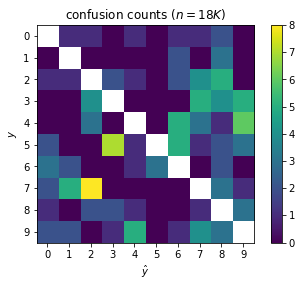

+--------------------+------------+
|   weighted roc auc |   accuracy |
+====================+============+
|           0.999807 |     0.9857 |
+--------------------+------------+
google error eval


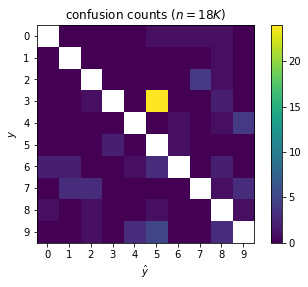

+--------------------+------------+
|   weighted roc auc |   accuracy |
+====================+============+
|           0.999966 |     0.9918 |
+--------------------+------------+


In [10]:
print('mlp-5 error eval')
evaluate(testy, final_pred['mlp-5'])
print('google error eval')
evaluate(testy, final_pred['google'])

In [11]:
# Looks like we can regularize google and mlp-5 a bit more!
# They also have complimentary confusion matrices, a weighted mixture might do better.